<a href="https://colab.research.google.com/gist/maya2d26/3d5415a469a9a53f159626d4c2c0f1ce/finalmilestone_resnet_multi.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Deep Learning Python és LUA alapokon -  Homework -Final**


---

***This notebook contains the image recognition task with ResNet for all the label.***


---



**Group name : * *Rise of AI* ***

Group Members: Tugyi Beatrix (T63K63), El-Ali Maya (BHI5LF), Simkó Máté (O3BMRX)

**Chosen task: Face Recognition and Generation**

**Dataset: [FairFace Datset](https://github.com/joojs/fairface)**

#Imports

In [1]:
!pip install torchmetrics
import torch
import torchvision
import torch.nn as nn
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset

import dlib
import matplotlib.pyplot as plt
import torchvision.transforms as transforms

from torch.utils.data.dataloader import DataLoader
from torchvision.utils import make_grid
from PIL import Image
import torch.nn.functional as F

from torchmetrics import Accuracy
from torchmetrics.classification import MultilabelAccuracy

from tqdm.notebook import tqdm #a progress bar for aesthetic training visualisation
import torchvision.models as models #for the models used in transfer learning

import datetime
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import seaborn as sns

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


#Loading the data

In [2]:
# getting the images
! wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=1Z1RqRo0_JiavaZw2yzZG6WETdZQ8qX86' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1Z1RqRo0_JiavaZw2yzZG6WETdZQ8qX86" -O data.zip && rm -rf /tmp/cookies.txt

--2022-12-11 18:38:41--  https://docs.google.com/uc?export=download&confirm=t&id=1Z1RqRo0_JiavaZw2yzZG6WETdZQ8qX86
Resolving docs.google.com (docs.google.com)... 142.250.4.139, 142.250.4.102, 142.250.4.138, ...
Connecting to docs.google.com (docs.google.com)|142.250.4.139|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://doc-0g-64-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/05duv5q7ntmnfd2hdptkpre61r0l5l74/1670783850000/03161587497725415728/*/1Z1RqRo0_JiavaZw2yzZG6WETdZQ8qX86?e=download&uuid=aa172756-925e-49cd-be09-1c49bacc2b00 [following]
--2022-12-11 18:38:41--  https://doc-0g-64-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/05duv5q7ntmnfd2hdptkpre61r0l5l74/1670783850000/03161587497725415728/*/1Z1RqRo0_JiavaZw2yzZG6WETdZQ8qX86?e=download&uuid=aa172756-925e-49cd-be09-1c49bacc2b00
Resolving doc-0g-64-docs.googleusercontent.com (doc-0g-64-docs.googleusercontent.com)... 74.125.24.132, 2404:

In [3]:
# getting the training labels
! wget --no-check-certificate 'https://docs.google.com/uc?export=download&id=1i1L3Yqwaio7YSOCj7ftgk8ZZchPG7dmH' -O "fairface_label_train.csv"

--2022-12-11 18:38:52--  https://docs.google.com/uc?export=download&id=1i1L3Yqwaio7YSOCj7ftgk8ZZchPG7dmH
Resolving docs.google.com (docs.google.com)... 142.250.4.139, 142.250.4.102, 142.250.4.138, ...
Connecting to docs.google.com (docs.google.com)|142.250.4.139|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://doc-04-64-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/op6am09ul9isofi0vdjej5adq6arjek6/1670783925000/03161587497725415728/*/1i1L3Yqwaio7YSOCj7ftgk8ZZchPG7dmH?e=download&uuid=1fb73c53-dc10-43d8-8edc-52221dd7e378 [following]
--2022-12-11 18:38:53--  https://doc-04-64-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/op6am09ul9isofi0vdjej5adq6arjek6/1670783925000/03161587497725415728/*/1i1L3Yqwaio7YSOCj7ftgk8ZZchPG7dmH?e=download&uuid=1fb73c53-dc10-43d8-8edc-52221dd7e378
Resolving doc-04-64-docs.googleusercontent.com (doc-04-64-docs.googleusercontent.com)... 74.125.24.132, 2404:6800:4003:

In [4]:
# getting the validation labels
! wget --no-check-certificate 'https://docs.google.com/uc?export=download&id=1wOdja-ezstMEp81tX1a-EYkFebev4h7D' -O "fairface_label_val.csv"

--2022-12-11 18:38:54--  https://docs.google.com/uc?export=download&id=1wOdja-ezstMEp81tX1a-EYkFebev4h7D
Resolving docs.google.com (docs.google.com)... 142.250.4.139, 142.250.4.102, 142.250.4.138, ...
Connecting to docs.google.com (docs.google.com)|142.250.4.139|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://doc-08-64-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/c1vpind2638ifjakk381r3flmo1aot4l/1670783925000/03161587497725415728/*/1wOdja-ezstMEp81tX1a-EYkFebev4h7D?e=download&uuid=1abc9874-c99a-494c-9089-d8117fa752b1 [following]
--2022-12-11 18:38:54--  https://doc-08-64-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/c1vpind2638ifjakk381r3flmo1aot4l/1670783925000/03161587497725415728/*/1wOdja-ezstMEp81tX1a-EYkFebev4h7D?e=download&uuid=1abc9874-c99a-494c-9089-d8117fa752b1
Resolving doc-08-64-docs.googleusercontent.com (doc-08-64-docs.googleusercontent.com)... 74.125.24.132, 2404:6800:4003:

In [5]:
#unzip the images
! unzip  *data.zip

Archive:  data.zip
replace train/1346.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


In [6]:
#number of training images
! ls train | wc -l

86744


In [7]:
#number of validation images
! ls val | wc -l

10954


#**Data Preprocessing**

In [8]:
#for encoding labels
def one_hot_df(df,target):
  #for age and race
  if(target != 'multi'):
    label = df[target]
    label= pd.get_dummies(label)
    return pd.concat([label], axis=1)
  #for multilabel task
  age = df['age']
  age = pd.get_dummies(age)
  race = df['race']
  race = pd.get_dummies(race)
  gender = df['gender']
  gender = pd.get_dummies(gender)
   
  return pd.concat([age,gender,race], axis=1)

#for encoding binary labels
def to_categorical(df,target):
  df[target] = df[target].astype('category')
  df[target] = df[target].cat.codes
  return df

#for encoding the given target label
def encode_target(train,valid,test,target):
  if(target == "gender"):
    Y_train = to_categorical(train,target)
    Y_valid = to_categorical(valid,target)
    Y_test = to_categorical(test,target)
  if(target == "multi"):
    Y_train = one_hot_df(train,target)
    Y_valid = one_hot_df(valid,target)
    Y_test = one_hot_df(test,target)
  if(target == "race" or target == "age"):
    Y_train = one_hot_df(train,target)
    Y_valid = one_hot_df(valid,target)
    Y_test = one_hot_df(test,target)
  return Y_train, Y_valid, Y_test

In [9]:
#function for preprocess the labels and images
def preprocess(target="multi"):
  #loading the labels
  train_df = pd.read_csv("fairface_label_train.csv")
  train_df = train_df.drop(['service_test'], axis=1)
  #FOR TESTING ONLY
  #train_df = train_df[:10000]
  print("Number of all training images: " + str(len(train_df)))
  valid_df = pd.read_csv("fairface_label_val.csv")
  valid_df = valid_df.drop(["service_test"], axis = 1)
  #FOR TESTING ONLY
  #valid_df = valid_df[:2000]
  print("Number of validation images: " + str(len(valid_df)))
  #splitting the data
  print("Splitting the data...")
  if(target != "multi"):
    train_x = train_df.loc[:, train_df.columns == "file"]
    train_y = train_df.loc[:, train_df.columns == target]
    X_train_raw, X_test_raw, y_train_raw, y_test_raw = train_test_split(train_x, train_y, test_size=0.1, random_state=42, stratify = train_y)
    print("Number of training images: " + str(len(X_train_raw)))
    print("Number of test images: " + str(len(X_test_raw)))
    valid_x = valid_df.loc[:, valid_df.columns == "file"]
    valid_y = valid_df.loc[:, valid_df.columns == target]
  else:
    train_x = train_df.loc[:, train_df.columns == "file"]
    train_y = train_df.loc[:, train_df.columns != "file"]
    X_train_raw, X_test_raw, y_train_raw, y_test_raw = train_test_split(train_x, train_y, test_size=0.1, random_state=42, stratify = train_y)
    print("Number of training images: " + str(len(X_train_raw)))
    print("Number of test images: " + str(len(X_test_raw)))
    valid_x = valid_df.loc[:, valid_df.columns == "file"]
    valid_y = valid_df.loc[:, valid_df.columns != "file"]
  #encoding the data
  print("Encoding target labels...")
  Y_train_, Y_valid_, Y_test_ = encode_target(y_train_raw, valid_y, y_test_raw, target)
  #When creating the test dataset using train_test_split, the indeces were also scrambled, so they need to be renumbered
  X_train_ = X_train_raw.reset_index(drop=True)
  Y_train_ = Y_train_.reset_index(drop=True)
  X_test_ = X_test_raw.reset_index(drop=True)
  Y_test_ = Y_test_.reset_index(drop=True)
  #renaming variable
  X_valid_ = valid_x
  print("Preprocessing finished!")

  return X_train_, Y_train_, X_valid_, Y_valid_, X_test_, Y_test_


#**Create a DataLoader for the images**

In [10]:
#Defining our own dataset
class FaceRecognitionDataset(Dataset):  
    def __init__(self, image_ds, label_ds, transform=None):
        self.label_ds = label_ds
        self.ds = image_ds
        self.transform = transform
        
    def __len__(self):
        return len(self.ds)
    #return one image and it's label according to the index
    def __getitem__(self, idx):
        img = dlib.load_rgb_image(self.ds["file"][idx])
        img = torchvision.transforms.ToPILImage()(img)
        label = self.label_ds.iloc[idx]
        label = torch.tensor(label)
        if self.transform:
            img = self.transform(img)  
            return img, label

In [11]:
# Trasformation of the Images
# On the train set: We Crop, Flip and Rotate and we transform both the train, test and valid datasets to tensors

train_transform = transforms.Compose([
    transforms.CenterCrop(224),
    transforms.RandomHorizontalFlip(p=0.3),
    transforms.RandomRotation(degrees=20),
    transforms.ToTensor(),  
    # we used the same mean and std thats been used to trained the base ResNet and VGG models 
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])
])

val_and_test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])
])

#**Set GPU usage**

In [12]:
#set the training device for cuda if it is avaible
def get_default_device():
  if torch.cuda.is_available():
    return torch.device('cuda')
  else:
    torch.device('cpu')
#CUDA check
device = get_default_device()
device

def to_device(data, device):
  if isinstance(data, (list, tuple)):
    return [to_device(x, device) for x in data]
  return data.to(device, non_blocking=True)

class DeviceDataLoader():
  def __init__(self, dl, device):
    self.dl = dl 
    self.device = device

  def __iter__(self):
    for b in self.dl:
      yield to_device(b, self.device)

  def __len__(self):
    return len(self.dl)

#**Define the training functions and the Model**

In [40]:
#custom accuracy
def accuracy(preds, labels): 

    #for binary labels
    if(preds.shape[1]==7 | preds.shape[1]==9 ): 
      _, preds = torch.max(preds, dim=1)
      _, labels = torch.max(labels, dim=1)
    #for multi labels
    elif(preds.shape[1] == 17):
      #split the predictions
      age_preds, gender_preds,race_preds = torch.split(preds, [9,1,7], dim=1)
      _, age_preds = torch.max(age_preds, dim=1)
      _, race_preds = torch.max(race_preds, dim=1)
      _, gender_preds = torch.max(gender_preds, dim=1)
       #split the labels
      age_labels, gender_labels,race_labels = torch.split(labels, [9,2,7], dim=1)
      _, age_labels = torch.max(age_labels, dim=1)
      _, race_labels = torch.max(race_labels, dim=1)
      _, gender_labels = torch.max(gender_labels,1)
      #get accuracy for every label
      age_acc = torch.tensor(torch.sum(age_preds == age_labels).item() / len(age_preds))
      race_acc = torch.tensor(torch.sum(race_preds == race_labels).item() / len(race_preds))
      gender_acc = torch.tensor(torch.sum(gender_preds == gender_labels).item() / len(gender_preds))
    
      accs = [age_acc, race_acc, gender_acc]
      return torch.mean(torch.tensor(accs, dtype = torch.float)), age_acc, race_acc, gender_acc
    #for race or age labels
    else:
      preds = torch.round(preds)  
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

In [41]:
#custom loss for multi target
def multi_target_loss(out, labels):
  # spliiting the outputs
  age_outputs, gender_outputs,race_outputs = torch.split(out, [9,1,7], dim=1)

  # creating float tensors
  age_pred = torch.tensor(age_outputs,dtype=torch.float32, device=device, requires_grad=True)
  gender_pred = torch.tensor(gender_outputs,dtype=torch.float32, device=device, requires_grad=True)
  race_pred = torch.tensor(race_outputs,dtype=torch.float32, device=device, requires_grad=True)

  labels = labels.type(torch.float32)

  # splitting the labels
  age_labels, gender_labels, race_labels = torch.split(labels,[9,2,7],dim=1)

  # transforming the gender label because it was one-hot encoded
  gender_labels = torch.argmax(gender_labels,1)
  gender_labels = gender_labels.resize_(gender_labels.shape[0],1)
  gender_labels = torch.tensor(gender_labels,dtype=torch.float32, device=device)

  # defining criterions
  loss_age = nn.CrossEntropyLoss()
  loss_gender = nn.BCELoss()
  loss_race = nn.CrossEntropyLoss()

  # calculating the losses
  age_loss = loss_age(age_pred,age_labels)
  gender_loss = loss_gender(gender_pred,gender_labels)
  race_loss = loss_race(race_pred,race_labels)
  
  return age_loss + gender_loss + race_loss

In [49]:
class ImageClassificationBase(nn.Module):
    # training step
    def training_step(self, batch):
        img, targets = batch
        out = self(img)
        targets = targets.type(torch.float32)

        # set the loss function
        if(out.shape[1] == 1):
          #for gender
          loss_fn = nn.BCELoss() 
        elif (out.shape[1] == 17):
          #for multilabels
          loss_fn = multi_target_loss
        else: 
          #for age and race
          loss_fn = nn.CrossEntropyLoss()

        loss = loss_fn(out, targets) 
        return loss
    
    # validation step
    def validation_step(self, batch):
        img, targets = batch
        targets = targets.type(torch.float32)
        out = self(img)
        #set the loss function
        loss_fn = multi_target_loss
        
        loss = loss_fn(out, targets) 
        targets = targets.type(torch.int32)
     
        # calculate the accuracy
        acc, a, r, g = accuracy(out, targets)
        return {'val_acc':acc,  'val_loss':loss, 'age':a, 'gender':g, 'race':r}
    
    # validation step at the end of the epoch
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()

        #get the accuracy for each label separately
        batch_gender_accs = [x['gender'] for x in outputs]
        epoch_gender_acc = torch.stack(batch_gender_accs).mean()
        batch_age_accs = [x['age'] for x in outputs]
        epoch_age_acc = torch.stack(batch_age_accs).mean()
        batch_race_accs = [x['race'] for x in outputs]
        epoch_race_acc = torch.stack(batch_race_accs).mean()
        
        print("gender", epoch_gender_acc, "age", epoch_age_acc, "race", epoch_race_acc)
        #return the valid loss and accuracy
        return {'val_loss':epoch_loss.item(), 'val_acc':epoch_acc.item(), 'age':epoch_age_acc, 'gender':epoch_gender_acc, 'race':epoch_race_acc}


    # Printing the results at the end of the epoch
    def epoch_end(self, epoch, result):
        print("Gender accuracy:", result['gender'], "Age accuracy:", result['age'], "Race accuracy:", result['race'])
        print("Epoch [{}] : train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}"
        .format(epoch, result["train_loss"], result["val_loss"], result["val_acc"]))

In [50]:
# Defining the model
class FaceClassificationMultiModel(ImageClassificationBase):
    def __init__(self, num_classes, h, base_model):
        super().__init__()       
        if base_model == "ResNet":
            self.network = torch.hub.load('pytorch/vision:v0.10.0', 'resnet50', pretrained=True)
        else:
            self.network = torch.hub.load('pytorch/vision:v0.10.0', 'vgg19', pretrained=True)
        
        #Change the last layers of the modells
        num_ftrs = self.network.fc.out_features
        # network for predicting race
        self.fc_race = nn.Sequential(
            nn.Linear(num_ftrs, h),
            nn.ReLU(inplace=True),
            nn.Linear(h,7),  # for the n output
            nn.Softmax(1)
        )
        # network for predicting age
        self.fc_age = nn.Sequential(
            nn.Linear(num_ftrs, h),
            nn.ReLU(inplace=True),
            nn.Linear(h,9),  # for the n output
            nn.Softmax(1)
        )
        # network for predicting gender
        self.fc_gender = nn.Sequential(
            nn.Linear(num_ftrs, h),
            nn.ReLU(inplace=True),
            nn.Linear(h,1),  # for the n output
            nn.Sigmoid()
        )
    def forward(self, xb):
        # resnet output
        xb = self.network(xb)
        # prediction for each target
        race = self.fc_race(xb)
        gender = self.fc_gender(xb)
        age = self.fc_age(xb)
        # concat the result
        result = torch.cat((age,gender,race),1)
        return result

In [51]:
def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

  #preprocessing images and labels    
def fit_one_cycle(epochs, max_lr, model, target, batch_size, weight_decay, grad_clip, opt_func):
    # preprocessing and creating data loaders
    X_train, Y_train, X_valid, Y_valid, X_test, Y_test = preprocess(target)
    train_dataset = FaceRecognitionDataset(X_train, Y_train, train_transform) 
    val_dataset = FaceRecognitionDataset(X_valid, Y_valid, val_and_test_transform)
    train_dl = DataLoader(train_dataset, batch_size, shuffle=True, num_workers=2, pin_memory=True)
    val_dl = DataLoader(val_dataset, batch_size, num_workers=2, pin_memory=True)
    train_dl = DeviceDataLoader(train_dl, device)
    val_dl = DeviceDataLoader(val_dl, device)

    torch.cuda.empty_cache()
    history = []
    optimizer = opt_func(model.parameters(), max_lr, weight_decay=weight_decay)
    # setting the learning rate scheduler
    sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epochs, steps_per_epoch=len(train_dl))
    for epoch in range(epochs):      
        # Training
        model.train()       
        train_losses = []
        lrs = []
        for batch in tqdm(train_dl):
            loss = model.training_step(batch)
            train_losses.append(loss)       
            # Gradient backpropogation
            loss.backward()            
            # Gradient clipping if needed
            if grad_clip:
                nn.utils.clip_grad_value_(model.parameters(), grad_clip)              
            # Performing gradient descent -> recalculating weights
            optimizer.step()           
            # Reset gradients
            optimizer.zero_grad()         
            # Save, update learning rate
            lrs.append(get_lr(optimizer))          
            sched.step()
            
        # Validation phase
        result = evaluate(model, val_dl)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        result['lrs'] = lrs
        model.epoch_end(epoch, result)
        history.append(result)
             
    return history

# For evaluating the test and the validation datasets -> no gradient calculation
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)
 
#For prediction
@torch.no_grad()
def predict(model, test_loader, target):
  preds = [model(img) for img, targets in test_loader]
  preds = [pred.cpu().detach().numpy() for pred in preds]
  if(target != "gender"):
    preds = [np.argmax(pred, axis=-1) for pred in preds]
  else:
    preds = [np.round(pred) for pred in preds]
  preds = [item for sublist in preds for item in sublist] 
  return preds

# **You can choose the type here!**

In [18]:
target = "multi" #"gender", "age", "race"

In [19]:
#initialise mode
if target == "multi":
  num_classes = 17
elif target == "gender":
   num_classes = 1
elif target == "age":
   num_classes = 9
else:
   num_classes = 7

#**Hyperparameter optimalization**

In [20]:
#hiperparameters for optimalization

opt_func = [torch.optim.SGD, torch.optim.Adam]
max_lr = [0.005, 0.001]
grad_clip = [0.1, 0.2] 
weight_decay = [1e-4, 1e-5]
batch_size = [16, 32]
hidden_size = [ 128, 256]
base_model = "ResNet" #, 'VGG'
num_epochs = 3

In [21]:
#function for running the optimalization with the actual parameters
def run(opt, lr, gc, wd, batch, h):
    Model = FaceClassificationMultiModel(num_classes, h, base_model)
    to_device(Model, device)
    history_RN = fit_one_cycle(num_epochs, lr, Model, target, batch, wd, gc, opt)
    return  history_RN

In [ ]:
#Optimalization
for opt in opt_func:
  for lr in max_lr:
    for gc in grad_clip:
      for wd in weight_decay:
        for batch in  batch_size:
           for h in  hidden_size:
              run(opt, lr, gc, wd, batch, h)           
              print(opt, lr, gc, wd, batch, h)

# **Final training**

In [52]:
#set hiperparameters
num_epochs = 10
opt_func = torch.optim.SGD
max_lr = 0.005
grad_clip = 0.2
weight_decay = 1e-4
batch_size = 32
hidden_size = 256
base_model = "ResNet" #, 'VGG'

Define the model

In [53]:
Model = FaceClassificationMultiModel(num_classes,hidden_size, base_model)
to_device(Model, device)

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


FaceClassificationMultiModel(
  (network): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): S

In [54]:
history_RN = fit_one_cycle(num_epochs, max_lr, Model, 'multi', batch_size, 
                           weight_decay, grad_clip, opt_func)

Number of all training images: 86744
Number of validation images: 10954
Splitting the data...
Number of training images: 78069
Number of test images: 8675
Encoding target labels...
Preprocessing finished!


  0%|          | 0/2440 [00:00<?, ?it/s]

<ipython-input-41-23325bea2bf6>:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  age_pred = torch.tensor(age_outputs,dtype=torch.float32, device=device, requires_grad=True)
<ipython-input-41-23325bea2bf6>:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  gender_pred = torch.tensor(gender_outputs,dtype=torch.float32, device=device, requires_grad=True)
<ipython-input-41-23325bea2bf6>:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  race_pred = torch.tensor(race_outputs,dtype=torch.float32, device=device, requires_grad=True)
<ipython-input-41

gender tensor(0.4709) age tensor(0.1102) race tensor(0.1374)
Gender accuracy: tensor(0.4709) Age accuracy: tensor(0.1102) Race accuracy: tensor(0.1374)
Epoch [0] : train_loss: 4.8805, val_loss: 4.8908, val_acc: 0.2395


  0%|          | 0/2440 [00:00<?, ?it/s]

gender tensor(0.4709) age tensor(0.1091) race tensor(0.1380)
Gender accuracy: tensor(0.4709) Age accuracy: tensor(0.1091) Race accuracy: tensor(0.1380)
Epoch [1] : train_loss: 4.8803, val_loss: 4.8902, val_acc: 0.2393


  0%|          | 0/2440 [00:00<?, ?it/s]

gender tensor(0.4709) age tensor(0.1085) race tensor(0.1382)
Gender accuracy: tensor(0.4709) Age accuracy: tensor(0.1085) Race accuracy: tensor(0.1382)
Epoch [2] : train_loss: 4.8807, val_loss: 4.8894, val_acc: 0.2392


  0%|          | 0/2440 [00:00<?, ?it/s]

gender tensor(0.4709) age tensor(0.1084) race tensor(0.1380)
Gender accuracy: tensor(0.4709) Age accuracy: tensor(0.1084) Race accuracy: tensor(0.1380)
Epoch [3] : train_loss: 4.8804, val_loss: 4.8896, val_acc: 0.2391


  0%|          | 0/2440 [00:00<?, ?it/s]

gender tensor(0.4709) age tensor(0.1077) race tensor(0.1370)
Gender accuracy: tensor(0.4709) Age accuracy: tensor(0.1077) Race accuracy: tensor(0.1370)
Epoch [4] : train_loss: 4.8809, val_loss: 4.8928, val_acc: 0.2385


  0%|          | 0/2440 [00:00<?, ?it/s]

gender tensor(0.4709) age tensor(0.1105) race tensor(0.1381)
Gender accuracy: tensor(0.4709) Age accuracy: tensor(0.1105) Race accuracy: tensor(0.1381)
Epoch [5] : train_loss: 4.8804, val_loss: 4.8920, val_acc: 0.2398


  0%|          | 0/2440 [00:00<?, ?it/s]

gender tensor(0.4709) age tensor(0.1078) race tensor(0.1371)
Gender accuracy: tensor(0.4709) Age accuracy: tensor(0.1078) Race accuracy: tensor(0.1371)
Epoch [6] : train_loss: 4.8805, val_loss: 4.8900, val_acc: 0.2386


  0%|          | 0/2440 [00:00<?, ?it/s]

gender tensor(0.4709) age tensor(0.1078) race tensor(0.1375)
Gender accuracy: tensor(0.4709) Age accuracy: tensor(0.1078) Race accuracy: tensor(0.1375)
Epoch [7] : train_loss: 4.8803, val_loss: 4.8905, val_acc: 0.2387


  0%|          | 0/2440 [00:00<?, ?it/s]

gender tensor(0.4709) age tensor(0.1083) race tensor(0.1394)
Gender accuracy: tensor(0.4709) Age accuracy: tensor(0.1083) Race accuracy: tensor(0.1394)
Epoch [8] : train_loss: 4.8804, val_loss: 4.8924, val_acc: 0.2395


  0%|          | 0/2440 [00:00<?, ?it/s]

gender tensor(0.4709) age tensor(0.1101) race tensor(0.1389)
Gender accuracy: tensor(0.4709) Age accuracy: tensor(0.1101) Race accuracy: tensor(0.1389)
Epoch [9] : train_loss: 4.8804, val_loss: 4.8899, val_acc: 0.2400


#Visualize History

In [55]:
#get the datas from the training history
val_loss = []
train_loss = []
val_acc = []
time = list(range(len(history_RN)))
for h in history_RN:
    val_loss.append(h['val_loss'])
    train_loss.append(h['train_loss'])
    val_acc.append(h['val_acc'])

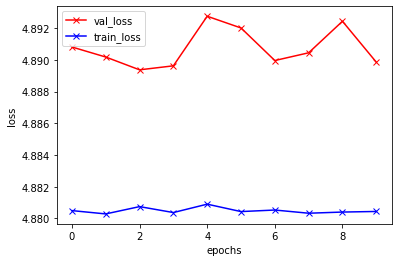

In [56]:
#Plot the changes in the training and validation loss functions
plt.plot(time, val_loss, c='red', label='val_loss', marker='x')
plt.plot(time, train_loss, c='blue', label='train_loss', marker='x')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()
plt.show()

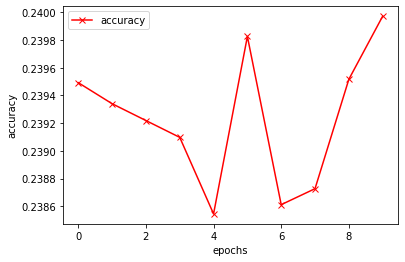

In [57]:
#Plot the changes in the validation accuracy
plt.plot(time, val_acc, c='red', label='accuracy', marker='x')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend()
plt.show()

#Save the model

In [58]:
torch.save(Model, 'ResnetModel_'+target+'_'+str(datetime.datetime.now())+'.pth')

## Get the datas for testing

In [59]:

X_train, Y_train, X_valid, Y_valid, X_test, Y_test = preprocess(target)
#Creating the datasets

test_dataset = FaceRecognitionDataset(X_test, Y_test, val_and_test_transform)
#Create the dataloaders
batch_size = 32
num_workers = 2
test_dl = DataLoader(test_dataset, batch_size, num_workers=num_workers, pin_memory=True)
#Creating the dataloaders on the used device
test_dl = DeviceDataLoader(test_dl, device)

Number of all training images: 86744
Number of validation images: 10954
Splitting the data...
Number of training images: 78069
Number of test images: 8675
Encoding target labels...
Preprocessing finished!


# **Test accuracy**

In [60]:
# calculate the accuracy
result = evaluate(Model, test_dl)
print("Test loss: " ,result['val_loss'])
print("Test accuracy: ",result['val_acc'])

<ipython-input-41-23325bea2bf6>:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  age_pred = torch.tensor(age_outputs,dtype=torch.float32, device=device, requires_grad=True)
<ipython-input-41-23325bea2bf6>:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  gender_pred = torch.tensor(gender_outputs,dtype=torch.float32, device=device, requires_grad=True)
<ipython-input-41-23325bea2bf6>:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  race_pred = torch.tensor(race_outputs,dtype=torch.float32, device=device, requires_grad=True)
<ipython-input-41

gender tensor(0.4693) age tensor(0.1163) race tensor(0.1440)
Test loss:  4.887715816497803
Test accuracy:  0.24317042529582977
